## Curse of Dimensionality
- Since in high dimensional data are at risk of being very sparse, most training instances are likely to be far away from each other. So of course this also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions.
- More dimensions the training set has, greater the risk of overfitting it.  

One solution to this could be to increase the size of the training set to reach a sufficient density of training instances. But that also grows exponentially with number of dimensions.  
<br>
## Approaches for Dimensionality Reduction
### Projection
- In real world problems, mostly training instances are not spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated.
- So as result, all training instances actually lie within (or close to) a much lower dimensional subspace of the high dimensional space.
- So this way uses projecting training instances from higher dimension subspace to lower dimension subspace. 
- Projection does not always help. Ex. *Swiss roll toy dataset*  

### Manifold Learning
- *Swiss Roll* is an example of 2D manifold.
- Simply put, 2D manifold is a 2D shape, that can be simply bent and twisted in a higher dimensional space.
- More generally d-dimensional manifold is a part of n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane.
- Many dimensionality algorithms work by modeling the Manifold on which the training instances lie called Manifold Learning. It holds the assumption called *manifold hypothesis* which holds that most real world high dimensional datasets lie close to a much lower dimensional manifold  
<br>

## Principal Component Analysis (PCA)
- First it identifies the hyperplane that lies cloesest to the data and then it projects the data onto it.
- **Preserving the variance:** Projection that preservs maximum amount of variance will most likely lose less information than the other projects. Another way to justify this choice is, the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis.
- **Principal Component:** The unit vector that defines the $i^{th}$ axis is called the $i^{th}$ *principal component* (PC). The direction of PCs is not stable but they will generally still lie on the same axis if data is purturbed slightly. In some cases pair of PCs may rotate or swap but then the plane they define will generally be the same.
- **SVD:** A standard matrix factorization technique that decomposes training set matrix into the matrix multiplication of three matrices $U$ $\sum V^T$ where $V$ containts all the PCs we are looking for. 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

Let's build a simple 3D dataset

In [3]:
np.random.seed(42)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m,3))
X[:,0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
X[:,1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:,2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

#### Principal Components  
PCA assumes dataset is centered around the origin and Scikit-learn's PCA takes care of centering dataset.

In [4]:
X_centered = X - X.mean(axis=0)
U,s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:,0]
c2 = Vt.T[:,1]

In [14]:
m,n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [15]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

#### Projecting Down to d Dimension  
$X_{d-proj} = XW_d$

In [17]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [18]:
X2D_using_svd = X2D

#### Using Scikit-Learn's PCA

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [21]:
X2D[:5]

array([[-0.690074  , -0.36150744],
       [ 1.39636097,  0.34497714],
       [ 1.00728461, -0.35025708],
       [ 0.2736333 , -0.50516373],
       [-0.91324535,  0.26290852]])

In [23]:
X2D_using_svd[:5]

array([[-0.690074  , -0.36150744],
       [ 1.39636097,  0.34497714],
       [ 1.00728461, -0.35025708],
       [ 0.2736333 , -0.50516373],
       [-0.91324535,  0.26290852]])

In [25]:
np.allclose(X2D, X2D_using_svd)

True

Recover 3D points projected on the plane (PCA 2D subspace).  
We may see some loss of information during projection step, so the recovered 3D points are not exactly to the original 3D points.  
But we can compute the reconstruction error.

In [30]:
X3D_inv = pca.inverse_transform(X2D)
print("Matching Actual and recovered 3D data",np.allclose(X3D_inv, X))
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

Matching Actual and recovered 3D data False


0.009421417196957218

In [31]:
#Inverse transform in SVD approach
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])
np.mean(np.sum(np.square(X3D_inv_using_svd - X), axis=1))

0.07278313972817166

The reconstructions from both methods are not identical because Scikit-Learn's PCA class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [32]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

Accessing PCs

In [33]:
pca.components_

array([[-0.95250178, -0.24902446, -0.17529172],
       [ 0.29267159, -0.9076305 , -0.30091563]])

Compare to the first PC using SVD

In [34]:
Vt[:2]

array([[-0.95250178, -0.24902446, -0.17529172],
       [ 0.29267159, -0.9076305 , -0.30091563]])

### Explained Variance Ratio   
It tells proportion of the dataset's variance that lies along the axis of each PC.  
Ex. Let's look at first 2 components of the 3D dataset.  

It tells us that 85.2% of the dataset's variance lies along the first axis and 13.6% lies along the second axis. This leaves less than 0.9% for the third axis, so it's reasonable to assume that it probably carries little information

In [37]:
print("explained variance ratio : ",pca.explained_variance_ratio_)
print("Missed variance: ", (1 - pca.explained_variance_ratio_.sum()))

explained variance ratio :  [0.85406025 0.13622918]
Missed variance:  0.009710567616013521


In [38]:
#Computing explained variance ratior usng SVD. (recall s is diagonal matrix S in the SVD formula)
np.square(s) / np.square(s).sum()

array([0.85406025, 0.13622918, 0.00971057])

### Choosing the Right number of Dimensions (Variance >= 95%)
It is prefferable to choose the number of dimensions that add up to sufficiently large portion of the variance (ex. 95%).  
But if required for visaulization, we generally want to reduce dimensionality to 2 or 3.  

Following code computes PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set's variance.

In [39]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [40]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [41]:
pca = PCA()

pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [45]:
d

154

#### Elbow Method
We can detect required dimensions by plotting variance as function of number of dimensions (cumsum). This will usually be an elbow in the curve, where explained variance stops growing fast.

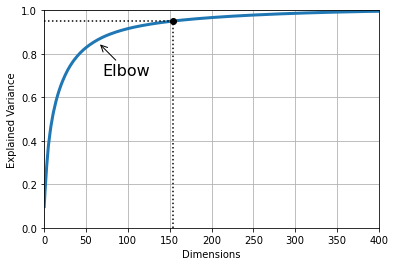

In [46]:
plt.figure(figsize=(6,4))

plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0 ,1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d,d], [0, 0.95], "k:")
plt.plot([0,d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")

plt.annotate("Elbow", xy=(65, 0.85), xytext = (70, 0.7),
            arrowprops = dict(arrowstyle="->"), fontsize=16)

plt.grid(True)
plt.show()

#### Specify explained ratio limit
We can also specify *n_components* as float between 0.0 to 1.0 indicating the ratio of variance we wish to preserve. 

In [47]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [48]:
pca.n_components_

154

In [50]:
np.sum(pca.explained_variance_ratio_)

0.9504506731634907

### PCA for Compression

In [72]:
pca  = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

X_reduced_pca = X_reduced

In [52]:
X_reduced.shape, X_recovered.shape

((52500, 154), (52500, 784))

In [60]:
def plot_digits(instances, images_per_row = 5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    
    n_rows = (len(instances) // images_per_row) + 1
    
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)
    
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

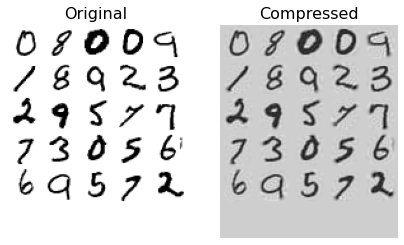

In [62]:
plt.figure(figsize=(7,4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)

plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)
plt.show()

> Equation of Inverse Transformation  
> $X_{recovered} = X_{d-proj}{W_d}^T$  
<br>
## Randomized PCA  
If we set **svd_solver= "randomized"**, Scikit-learn uses stochastic algorithm called ***Randomized PCA*** that quickly finds an approximation of the first *d* principal components.  
It's computational complexity is $O(md^2) + O(d^3)$.  
Full SVD approach has complexity $O(mn^2) + O(n^3)$.  

Scikit-learn automatically uses Randomized PCA algorithm if m or n is grater than 500 and d is less than 80% of m or n or else it uses full SVD approach. 

In [63]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Incremental PCA (IPCA)  
### Standard way to feed data
One problem with previous implementations of PCA was that they require the whole training set to fit in the memory in order for the algorithm to run. Fortunately, ***Incemental PCA*** algorithms have been developed, i.e. we can split the training set into mini batches and feed an IPCA algorithm one mini batch at a time.  
This is useful to apply PCA online.

In [73]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [74]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

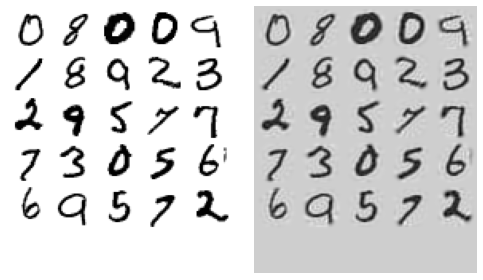

In [75]:
plt.figure(figsize=(7,4))
plt.subplot(121)
plot_digits(X_train[::2100])

plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()
plt.show()

In [76]:
X_reduced_inc_pca = X_reduced

Comparing results of transforming MNIST using regular PCA and incremental PCA. First the means are equal

In [77]:
np.allclose(pca.mean_, inc_pca.mean_)

True

But the results are not exactly identical. Incremental PCA gives a very good approximate solution but not perfect

In [78]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

### Using memmap():  
It allows us to manipulate a large array stored in a binary file on disk as if it were entirely in memory.  
The class loads only the data it needs in memory, when it needs it.  

Let's create a memmap structure and copy MNIST data into it.

In [79]:
filename = "my_mnist.data"
m,n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m,n))
X_mm[:] = X_train

In [80]:
del X_mm

Now let's load the data to use it for training PCA

In [81]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m,n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

**Time Complexity:**  
Let's time regular PCA against incremental PCA and Randomized PCA for various number of PCs

In [82]:
import time

for n_components in (2, 10 ,154):
    print("n_components: ", n_components)
    regular_pca = PCA(n_components = n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components = n_components, svd_solver="randomized", random_state=42)
    
    for name, pca in (("PCA", regular_pca), ("Inc PCA", inc_pca), ("Rnd PCA", rnd_pca)):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("  {}: {:.1f} seconds".format(name, t2- t1))

n_components:  2
  PCA: 2.9 seconds
  Inc PCA: 5.5 seconds
  Rnd PCA: 0.8 seconds
n_components:  10
  PCA: 2.9 seconds
  Inc PCA: 6.3 seconds
  Rnd PCA: 0.9 seconds
n_components:  154
  PCA: 2.7 seconds
  Inc PCA: 7.6 seconds
  Rnd PCA: 2.2 seconds


Let's compare PCA and Randomized PCA for datasets of different sizes (Number of instances):

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity')

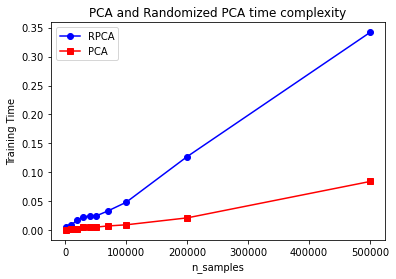

In [83]:
times_rpca = []
times_pca = []

sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]

for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training Time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity")

And now let's compare their performance on datasets of 2,000 instances with various numbers of features:

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

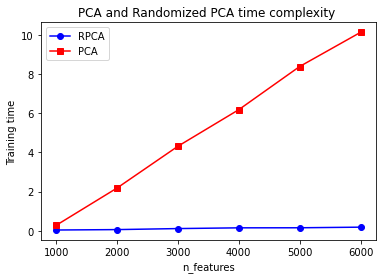

In [84]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

## Kernel PCA (kPCA)
The kernel trickm a mathematical technique that implicitly maps instances into a very high dimensional space (called as feature space), enabling nonlinear classification and regression with SVMs. Recall that a linear decision boundry in the high dimensional feature space corrsponds to a complex nonlinear decision boundry in the original space.  
So using same trick, we can perform complex nonlinear projections for dimensionality reduction using ***Kernel PCA***.  

- It is often good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted manifold.

In [89]:
from sklearn.datasets import make_swiss_roll
X , t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [90]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

Let's reduce Swiss roll to 2 dimensions using linear kernel (simply equivalent of using PCA class),  RBF kernel and Sigmoid kernel

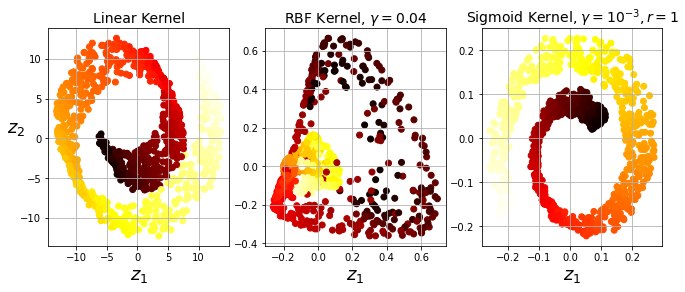

In [91]:
lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11,4))

for subplot, pca , title in ((131, lin_pca, "Linear Kernel"), (132, rbf_pca, "RBF Kernel, $\gamma=0.04$"),
                            (133, sig_pca, "Sigmoid Kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    
    if subplot == 132:
        X_reduced_rbf = X_reduced
        
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
    
plt.show()

### Kernel PCA and the reconstruction pre-image error:

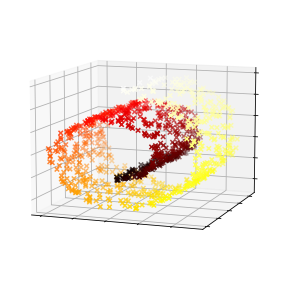

In [95]:
#from mpl_toolkits.mplot3d import proj3d
#from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(6,5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection="3d")
ax.view_init(10, -70)
ax.scatter(X_inverse[:,0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap = plt.cm.hot, marker = "x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

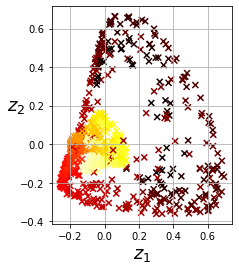

In [96]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

## Selecting a Kernel and Tuning Hyperparameters
**Note:** Used double underscore to determine hyperparamter in Pipeline. ex. kpca__gamma  

- **For Supervised Learning task:** We can simply used grid search to select best hyperparameters and kernel to get best performance on the task if used as data preparation step for supervised learning task.  
- **For Unsupervised Learning task:** Select the kernel and hyperparameter that yeilds the lowest reconstruction error. However reconstruction is not as easy as with ***linear*** kernel due to limitations to compute reconstruction error. Fortunately it is possible to find a point in the original space that would map close to the reconstructed point. This is called as ***pre-image.*** So then you can use grid-search with cross-validation to find the kernel and hyperparameter that minimized this *pre-image reconstruction error.*

### For Supervised Learning Task

In [98]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [99]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


### How to Perform Reconstruction?
One solution is to train a supervised regression model, with projected instances as training set and the original instances as the targets.  
Scikit-learn will do this automatically if you set ***fit_inverse_transform=True***.  
Scikit-learn uses ***Kernel Ridge Regression*** for this process.

> By default fit_inverse_transform is False and KernelPCA has no method inverse_transform(). It'll get created only when we specify True

In [100]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [101]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

9.00817556667947e-27

## Locally Linear Embedding (LLE)  
- It is a very powerful Nonlinear Dimensionality Reduction (NLDR) technique.
- It is **Manifold Learning** technique that does not rely on projections.
- It works by first measuring how each training instance linearly related to its closest neighbors (c.n.) and then looking for a low-dimensional representation of the training set where these local relationships are best preserved (more details shortly).
- This makes it perticularly good at unrolling twisted manifolds, especially whenre there is not too much noise.  

Ex. Following code unrolls Swiss roll. As we can see, Swiss roll is completely unrolled and the distances between instances are locally well preserved. However distances are not preserved on larger scale, i.e. left part of the unrolled Swiss roll is stretched while the right part is sqeezed.  

Scikit-Learn's LLE has following Computational Complexity,  
Finding k nearest neighbors - $O(m log(m) n log(k))$  
Optimizing Weights - $O(mnk^3)$  
Constructing low dimensional representation - $O(dm^2)$  - $m^2$ is the last term that makes this algorithm scale poorly

In [2]:
import numpy as np
from sklearn.datasets import make_swiss_roll

X, t= make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [3]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

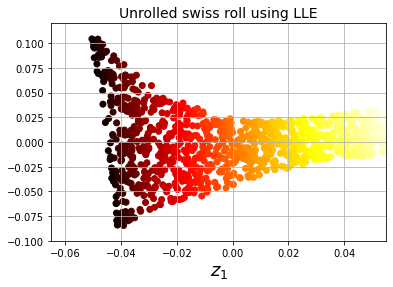

In [6]:
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt

plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:,0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.xlabel("$z_1$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

## Other Dimensionality Reduction Techniques
### Multidimensional Scaling (MDS) 
It reduces dimensionality while trying to preserve the distances between the instances.

### Isomap
It creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the geodesic distances between instances.

### t-Distributed Stochastic Neighbor Embedding (t-SNE)
It reduces dimensionality while trying to keep similar instances closer and dissimilar instaces apart. It is mostly used for visualization, in perticular to visualize clusters of instances in high dimensional space

### Linear Discriminant Analysis (LDA)
It is actually a classification algorithm, but during training it learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data. The benefit is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm such as SVM classifier.

In [7]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [8]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [9]:

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

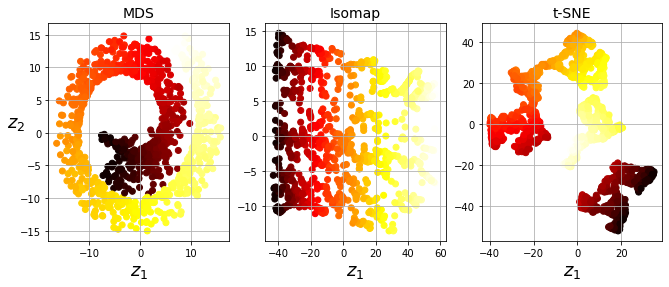

In [10]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

## Excercise
Load the MNIST dataset (introduced in chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).

In [12]:

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

Exercise: Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.

In [13]:
from sklearn.ensemble import RandomForestClassifier
import time

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

t0 = time.time()
rnd_clf.fit(X_train,y_train)
t1 = time.time()
print("Training time {:.2f}s ".format(t1 - t0))

from sklearn.metrics import accuracy_score
y_pred = rnd_clf.predict(X_test)
print("accuracy: ", accuracy_score(y_test, y_pred))

Training time 35.49s 
accuracy:  0.9705


Exercise: Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

Exercise: Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster?

In [15]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced,y_train)
t1 = time.time()
print("Training time {:.2f}s ".format(t1 - t0))

Training time 77.63s 


Oh no! Training is actually more than twice slower now! How can that be? Well, as we saw in this chapter, dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm.  If you try a softmax classifier instead of a random forest classifier, you will find that training time is reduced by a factor of 3 when using PCA. Actually, we will do this in a second, but first let's check the precision of the new random forest classifier.

Exercise: Next evaluate the classifier on the test set: how does it compare to the previous classifier?

In [16]:
X_test_reduced = pca.transform(X_test)
y_pred = rnd_clf2.predict(X_test_reduced)
print("accuracy: ", accuracy_score(y_test, y_pred))

accuracy:  0.9481


It is common for performance to drop slightly when reducing dimensionality, because we do lose some useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training and reduced performance.

Let's see if it helps when using softmax regression:

In [17]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()
print("Training time {:.2f}s".format(t1-t0))

Training time 9.01s


C:\Users\mruty\anaconda3\envs\opencv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [18]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

Okay, so softmax regression takes much longer to train on this dataset than the random forest classifier, plus it performs worse on the test set. But that's not what we are interested in right now, we want to see how much PCA can help softmax regression. Let's train the softmax regression model using the reduced dataset:

In [19]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()
print("Training time {:.2f}s".format(t1-t0))

Training time 4.19s


C:\Users\mruty\anaconda3\envs\opencv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Nice! Reducing dimensionality led to over 2× speedup. :) Let's check the model's accuracy:

In [21]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

A very slight drop in performance, which might be a reasonable price to pay for a 2× speedup, depending on the application.

So there you have it: PCA can give you a formidable speedup... but not always! 

**Exercise:** Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class.

The MNIST dataset was loaded above.

Dimensionality reduction on the full 60,000 images takes a very long time, so let's only do this on a random subset of 10,000 images:

In [22]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist["data"][idx]
y = mnist["target"][idx]

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=
           42)
X_reduced = tsne.fit_transform(X)

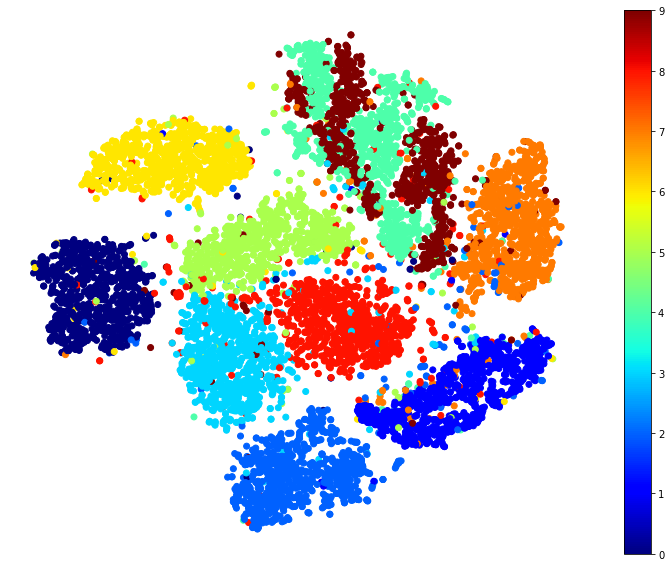

In [24]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:,0], X_reduced[:, 1] , c = y, cmap="jet")
plt.axis("off")
plt.colorbar()
plt.show()

This plot tells us which numbers are easily distinguishable from the others (e.g., 0s, 6s, and most 8s are rather well separated clusters), and it also tells us which numbers are often hard to distinguish (e.g., 4s and 9s, 5s and 3s, and so on).  


Let's focus on digits 2, 3 and 5, which seem to overlap a lot.

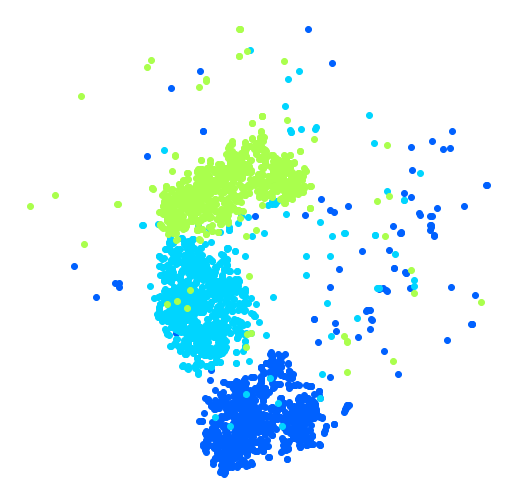

In [27]:
import matplotlib as mpl
plt.figure(figsize=(9,9))

cmap = mpl.cm.get_cmap("jet")
for digit in (2,3,5):
    plt.scatter(X_reduced[y == digit, 0] ,X_reduced[y == digit, 1], c= [cmap(digit/9)])
    
plt.axis("off")
plt.show()

Let's see if we can produce a nicer image by running t-SNE on these 3 digits:

In [28]:
idx = (y ==2) | (y ==3) | (y == 5)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

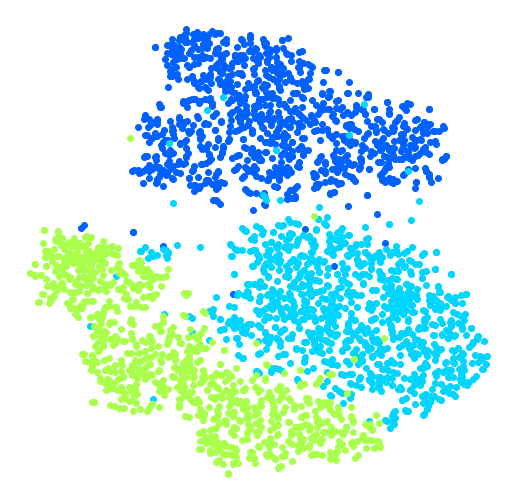

In [29]:
plt.figure(figsize=(9,9))
for digit in (2,3,5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis("off")
plt.show()

Much better, now the clusters have far less overlap. But some 3s are all over the place. Plus, there are two distinct clusters of 2s, and also two distinct clusters of 5s. It would be nice if we could visualize a few digits from each cluster, to understand why this is the case. Let's do that now.

Exercise: Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits.

Let's create a plot_digits() function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead. This implementation was inspired from one of Scikit-Learn's excellent examples (plot_lle_digits, based on a different digit dataset).

In [30]:

from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

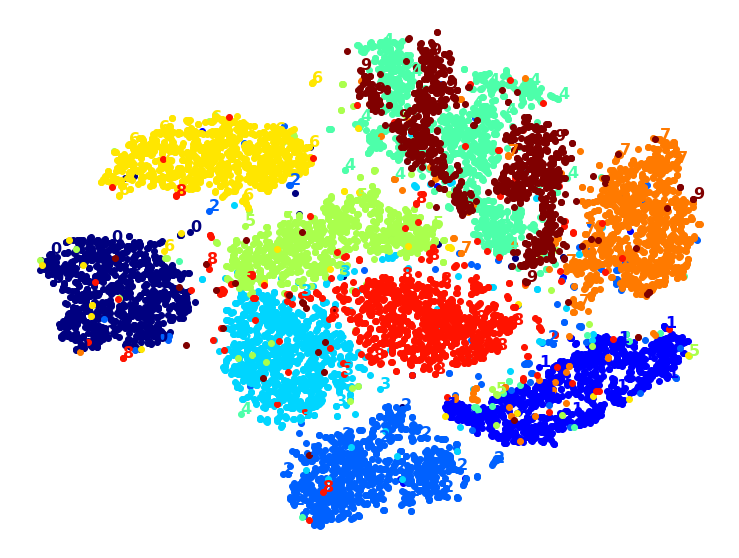

In [31]:
plot_digits(X_reduced, y)

Well that's okay, but not that beautiful. Let's try with the digit images:

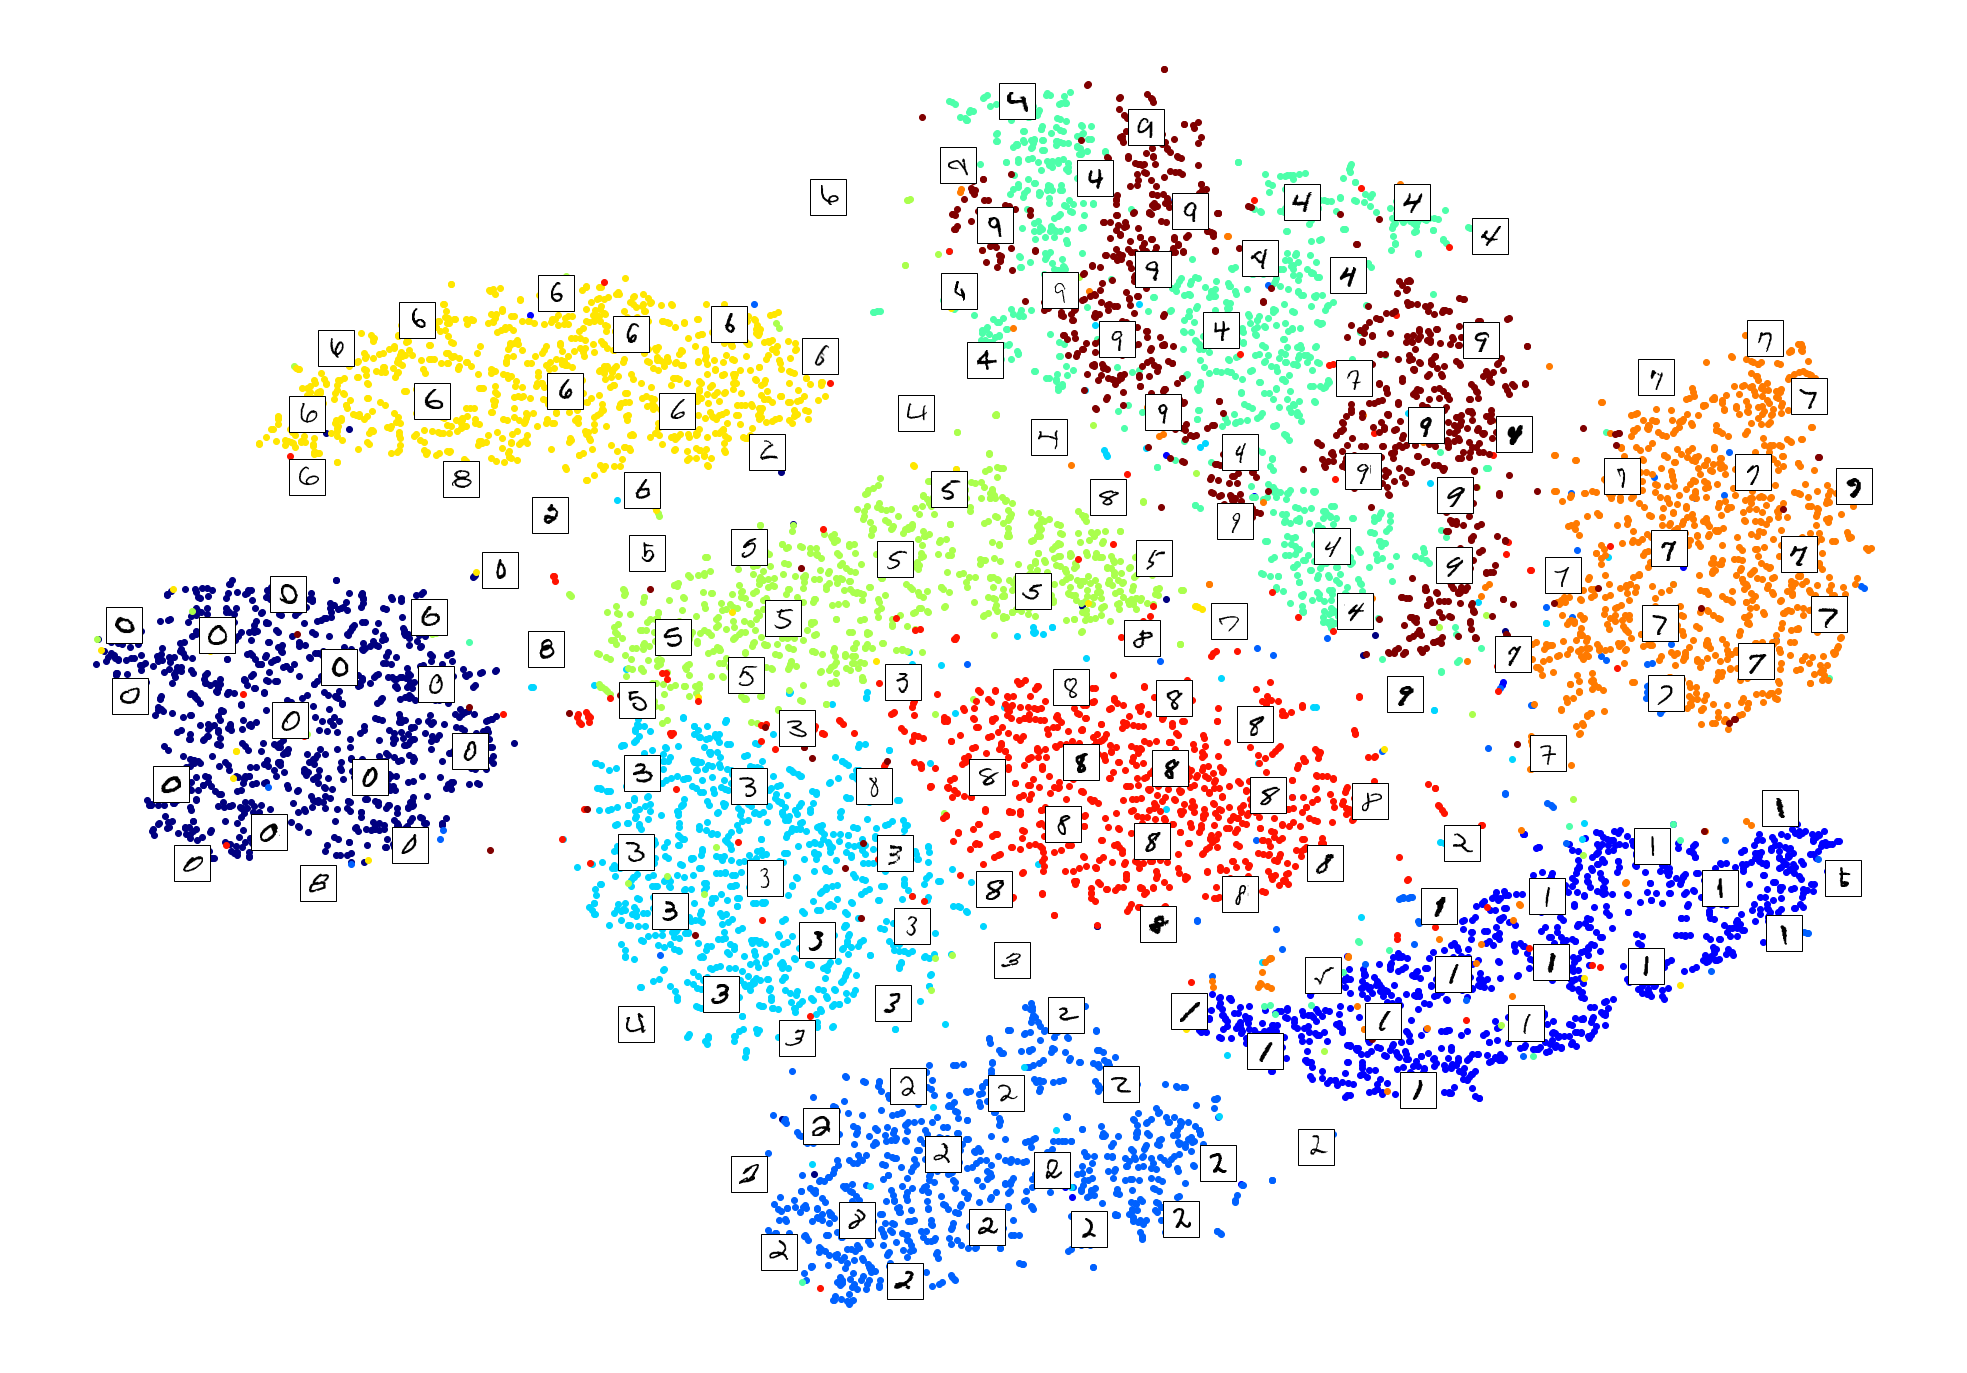

In [32]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

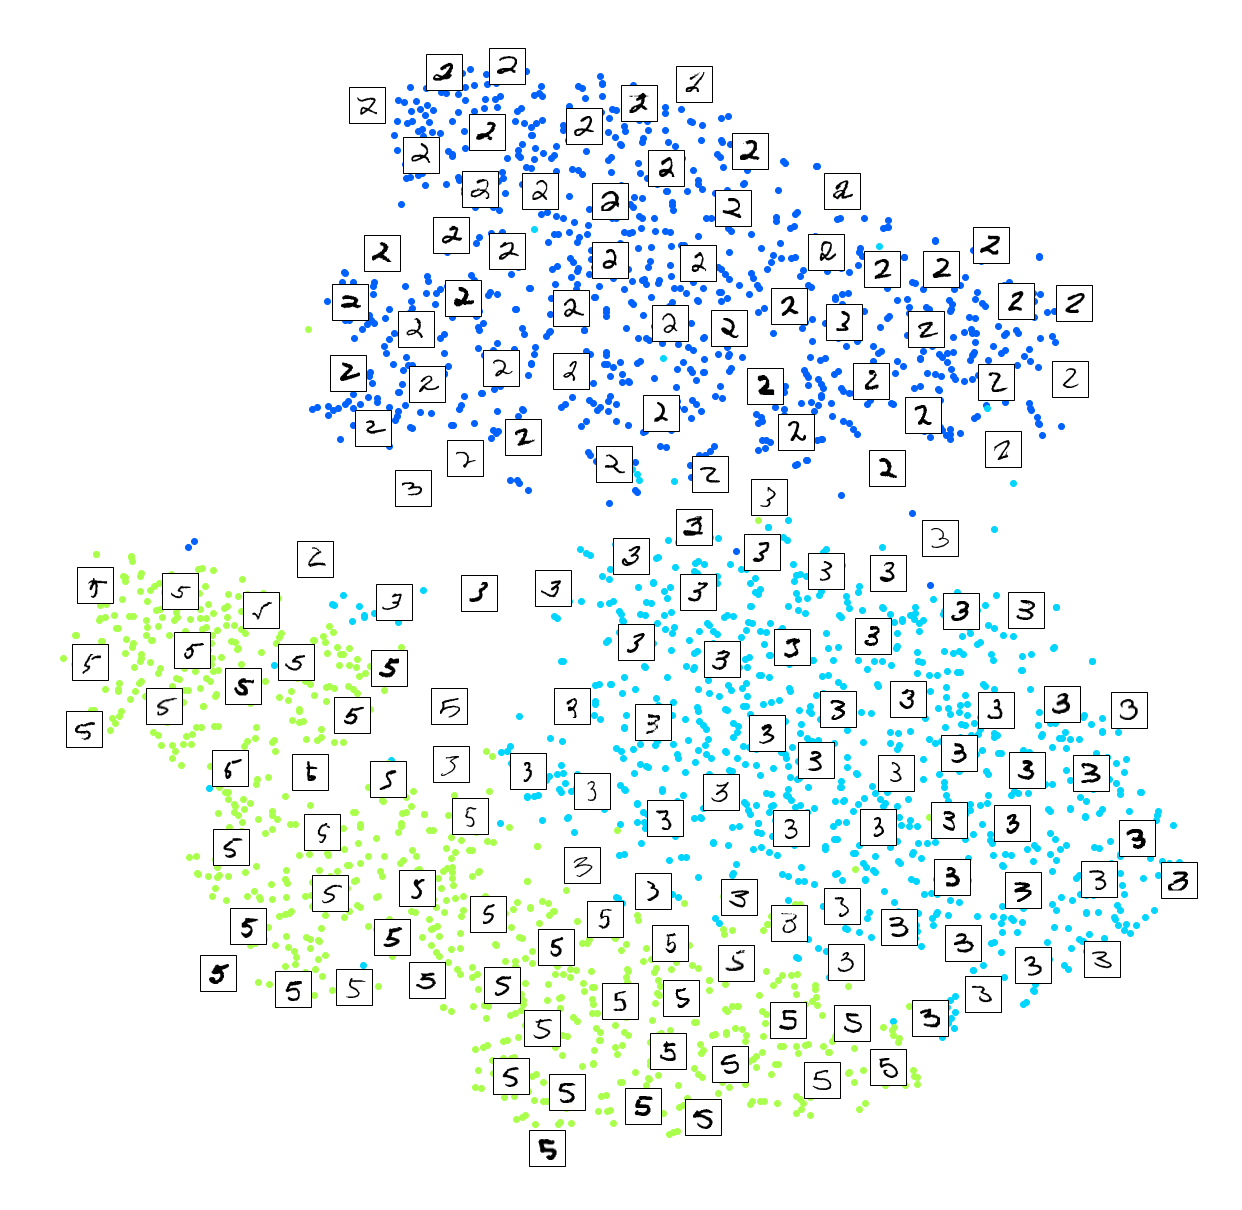

In [33]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

Exercise: Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

Let's start with PCA. We will also time how long it takes:

PCA took 0.2s.


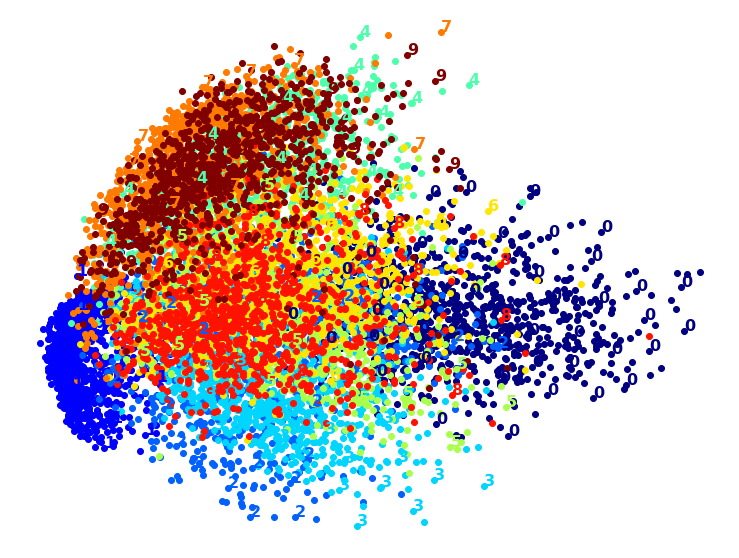

In [34]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

Wow, PCA is blazingly fast! But although we do see a few clusters, there's way too much overlap. Let's try LLE

LLE took 10.8s.


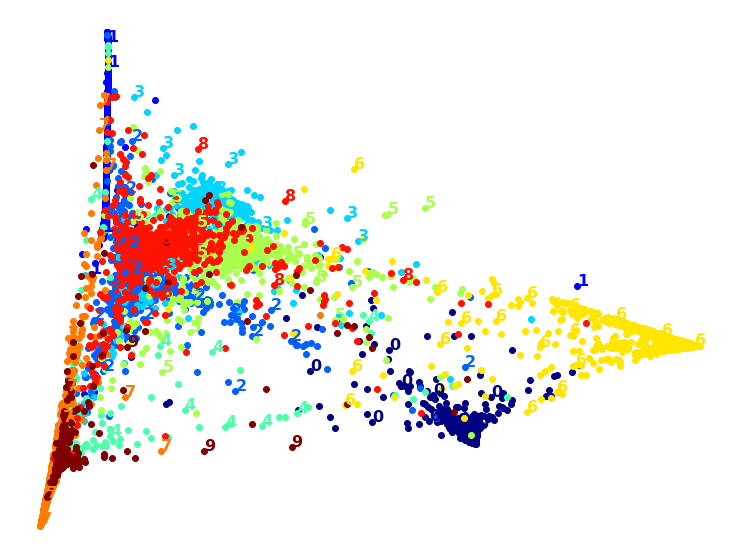

In [35]:

from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

That took a while, and the result does not look too good. Let's see what happens if we apply PCA first, preserving 95% of the variance:

PCA+LLE took 11.9s.


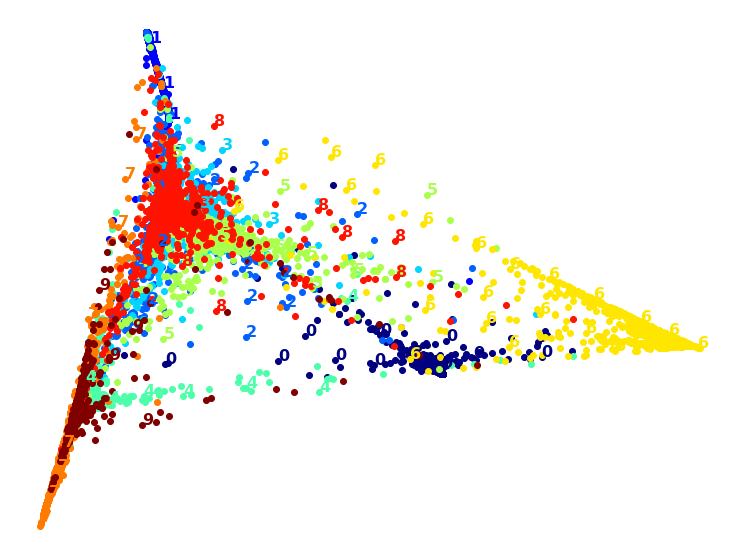

In [36]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

The result is more or less the same.

Let's try MDS. It's much too long if we run it on 10,000 instances, so let's just try 2,000 for now:

MDS took 121.6s (on just 2,000 MNIST images instead of 10,000).


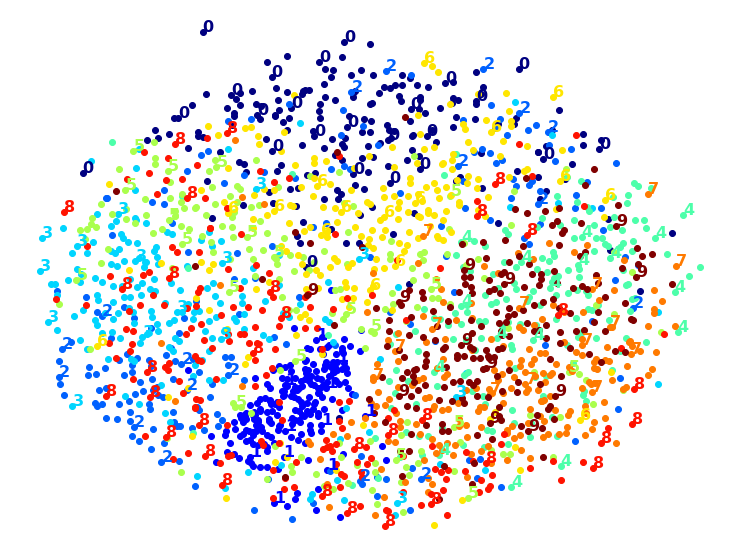

In [37]:

from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

Meh. This does not look great, all clusters overlap too much. Let's try with PCA first, perhaps it will be faster?

PCA+MDS took 120.3s (on 2,000 MNIST images).


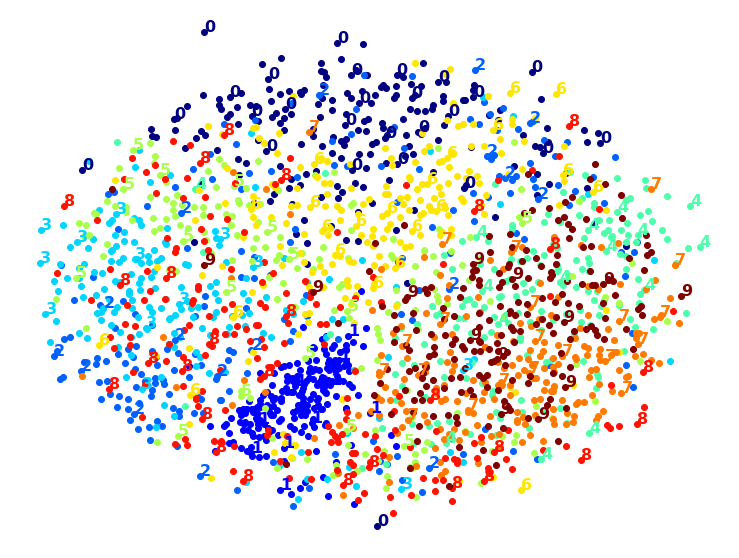

In [38]:

from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()


Same result, and no speedup: PCA did not help (or hurt).

Let's try LDA:

LDA took 1.1s.


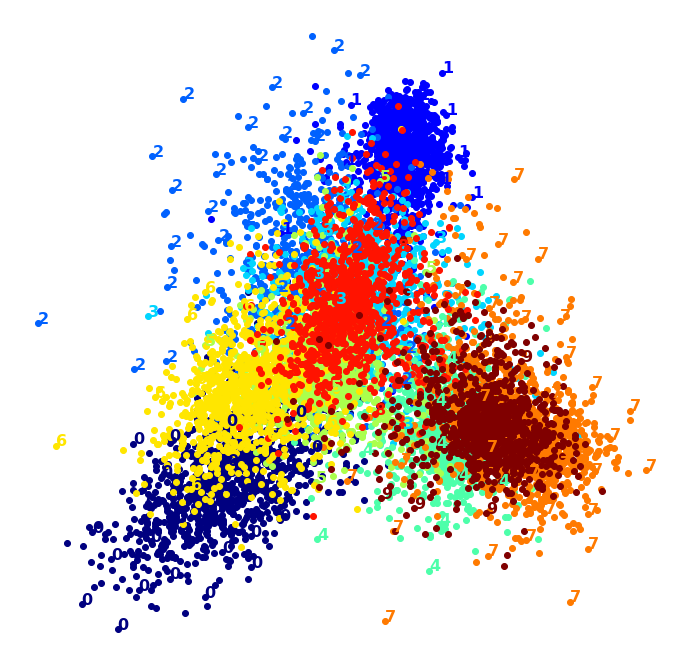

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA took {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

Well, it's pretty clear that t-SNE won this little competition, wouldn't you agree? We did not time it, so let's do that now:

t-SNE took 53.6s.


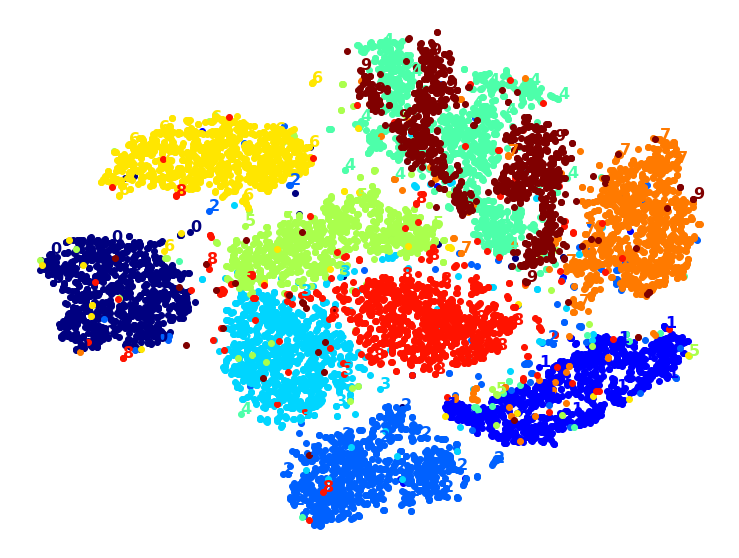

In [40]:

from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

It's twice slower than LLE, but still much faster than MDS, and the result looks great. Let's see if a bit of PCA can speed it up:

PCA+t-SNE took 55.9s.


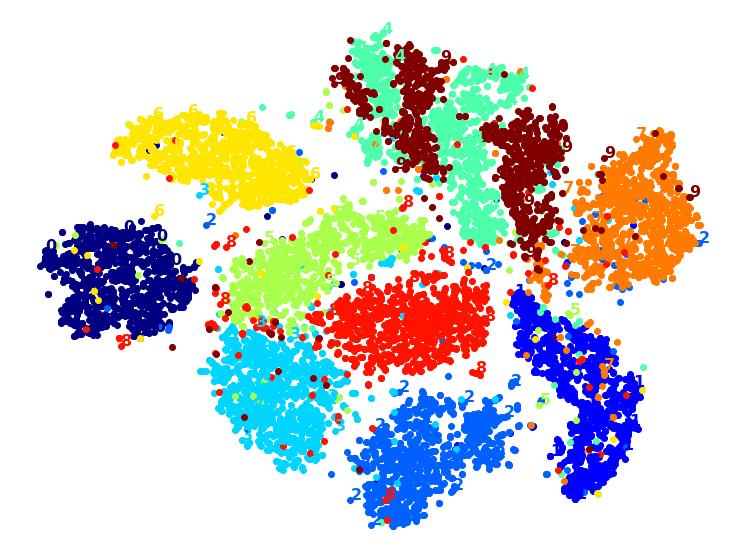

In [41]:

pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

PCA roughly gave us no speedup here unlike the author repo. Maybe my 8 core CPU, without damaging the result. We have a winner!